In [26]:
%env OMP_NUM_THREADS=8

env: OMP_NUM_THREADS=8


In [27]:
%pylab inline
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import theano
theano.config.floatX = 'float32'
import theano.tensor as T

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [28]:
from itertools import *

In [12]:
import pickle
#from hep_ml.reweight import BinsReweighter
import numpy as np
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

def get_weight(energy1_, energy2_):
    reweighter = BinsReweighter()
    reweighter.fit(energy1_, energy2_) #energy
    X1_weights = reweighter.predict_weights(energy1_)
    sampler = np.random.choice(np.arange(len(energy1_)),
                               p = X1_weights/X1_weights.sum(),
                               replace=False,
                               size=len(energy2_))

    energy2_ = numpy.array(energy2_)
    energy1_ = numpy.array(energy1_)
    X1_w = energy1_[sampler]

    weight2 = np.ones(len(energy2_))
    print type(weight2), type(X1_weights)
    weights_ = np.concatenate((X1_weights, weight2), axis = 0)
    plt.hist(energy2, bins = 50,alpha=0.5)
    plt.hist(X1_w, bins = 50,alpha=0.5)
    plt.show()
    return weights_

def rev_(X_train):
    X_train_rev = list()
    for elem in X_train:
        X_train_rev.append(elem.ravel())
    X_train_rev = np.array(X_train_rev)
    return X_train_rev

def get_fpr(tpr_val, tpr_, fpr_):
    new_trp = [abs(tpr_-0.9)]
    index = np.argmin(new_trp)
    return fpr_[index]

def write_data(str1, str2):
    with open(str1) as f_in:
        X1, hypo1, y1, energy1 = pickle.load(f_in)

    with open(str2) as f_in:
        X2, hypo2, y2, energy2 = pickle.load(f_in)
    print X1[9].shape, X2[9].shape
    print len(X1)
    print np.array(X1).shape
    return np.array(X1), np.array(hypo1), np.array(y1), np.array(energy1), np.array(X2), np.array(hypo2), np.array(y2), np.array(energy2)

def preprocess(str1, str2):
    X1, hypo1, y1, energy1, X2, hypo2, y2, energy2 =  write_data(str1, str2)
    print X1.shape, X2.shape
    X_all = np.concatenate((X1, X2), axis=0)
    print "X_all shape", X_all.shape
    Y_all = np.concatenate((y1, y2), axis=0)
    #weights = get_weight(energy1, energy2)
    weights = np.ones(len(X_all))
    X_train,X_val,y_train,y_val, w_train, w_test = train_test_split(X_all,Y_all,weights)
    return X_train,X_val,y_train,y_val, w_train, w_test

In [ ]:
X_train,X_val,y_train,y_val, w_train, w_val = preprocess("../obt_data/ReconstructionPi0.pcl", "../obt_data/ReconstructionPh.pcl")

In [13]:
X_train,X_val,y_train,y_val, w_train, w_val = preprocess("../obt_data/ReconstructionPi0.pcl", "../obt_data/ReconstructionPh.pcl")

(2, 5, 5) (2, 5, 5)
42622
(42622,)
(42622,) (232330,)
X_all shape (274952,)


In [20]:
with open("../obt_data/ReconstructionPi0.pcl") as f_in:
        X1, hypo1, y1, energy1 = pickle.load(f_in)


In [21]:
print len(X1)
a = X1[0].shape
print a
for elem in X1:
    if (elem.shape != a):
        print elem.shape
print np.array(X1).shape

42622
(2, 5, 5)
(42622, 2, 5, 5)


In [4]:
%load_ext autoreload
%autoreload 2

import dem

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
%pylab inline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

class xgbClf:
    xgb_clf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05, max_depth = 5, min_child_weight = 2)
    xtest_ex = []
    def __init__(self, photons_init_str, pi0s_init_str):
        X_train,X_val,y_train,y_val, w_train, w_val = dem.preprocess("../obt_data/RecArea2Pi0.pcl", "../obt_data/RecArea2Ph.pcl")
        self.xtest_ex = X_val
        print "preprocessing succeed"
        a = dem.rev_(X_train)
        print a.shape
        self.xgb_clf.fit(dem.rev_(X_train), y_train, w_train)
        print "fitting succeed"
        valid_answ = self.xgb_clf.predict_proba(dem.rev_(X_val))
        print "On val:", roc_auc_score(y_val, valid_answ[:,1])
        fpr_, tpr_, thresholds_ = roc_curve(y_val, valid_answ[:,1])
        plt.plot(fpr_, tpr_, label="Roc-Curve")
        plt.savefig("2areaNot.png")
        
    def predict_prob(self,test_sample):
        return self.xgb_clf.predict_proba(test_sample)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


X_all shape (236093, 2, 5, 5)
preprocessing succeed
(177069, 50)
fitting succeed
On val: 0.951255434717


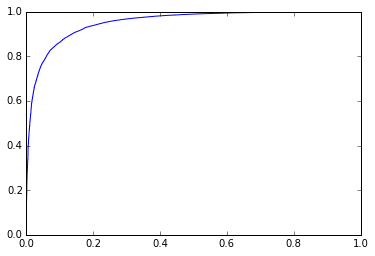

In [47]:
clf = xgbClf("../obt_data/ReconstructionPi0.pcl", "../obt_data/ReconstructionPh.pcl")

X_all shape (202971, 2, 5, 5)
preprocessing succeed
(152228, 50)
fitting succeed
On val: 0.949669788969


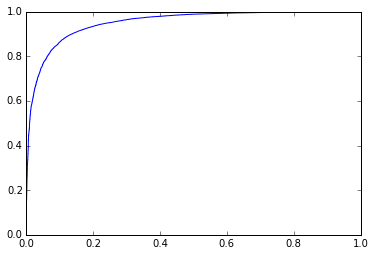

In [43]:
clf = xgbClf("../obt_data/ReconstructionPi0Not.pcl", "../obt_data/ReconstructionPhNOT.pcl")

X_all shape (236093, 2, 5, 5)
preprocessing succeed
(177069, 50)
fitting succeed
On val: 0.951964334546


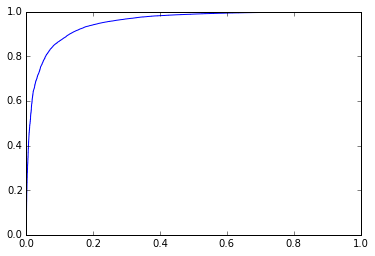

In [50]:
clf = xgbClf("../obt_data/ReconstructionPi0Not.pcl", "../obt_data/ReconstructionPhNOT.pcl")

**Сэмплом**

In [30]:
answ_ex = clf.predict_prob(dem.rev_(clf.xtest_ex))
print len(answ_ex)

5000


** По одному квадрату**

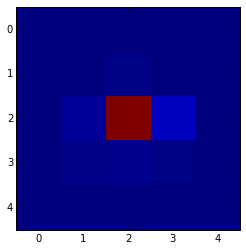

prob [[ 0.16780955  0.83219045]]


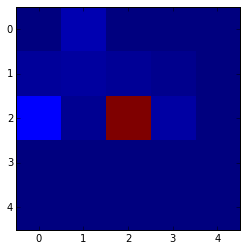

prob [[ 0.1353178  0.8646822]]


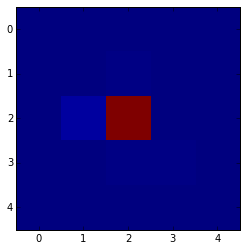

prob [[ 0.02460259  0.97539741]]


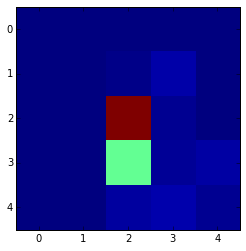

prob [[ 0.01442575  0.98557425]]


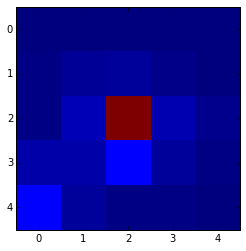

prob [[ 0.04585814  0.95414186]]


In [38]:
import matplotlib.pyplot as plt

for square in clf.xtest_ex[20:25]:
    plt.imshow(square[0].reshape(5,5), interpolation='nearest')
    plt.show()
    print "prob", clf.predict_prob(square.reshape(1,50))